<a href="https://colab.research.google.com/github/ishaanj2000/Hackerrank_code_python/blob/master/potato_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import PIL
import PIL.Image
import torch

#unzip the dataset
!unzip '/content/drive/MyDrive/ML LAB/PlantVillage.zip'

Archive:  /content/drive/MyDrive/ML LAB/PlantVillage.zip
replace __MACOSX/._PlantVillage? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Constants used throughout the code
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 35

#image dataset is taken as a variable dataset

#creates a batch dataset and not a dataframe 
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/PlantVillage', shuffle= True, image_size= (IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, )



Found 2152 files belonging to 3 classes.


In [ ]:
# 3 classes are recognized by tensorflow from our dataset
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


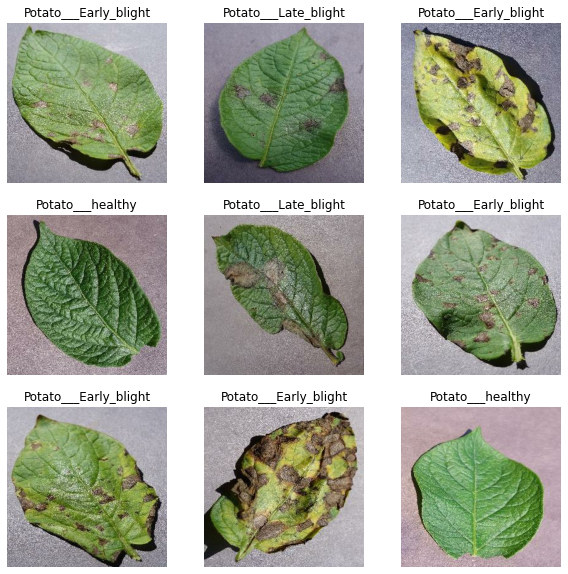

In [ ]:
#visualize the dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#every recored in the dataset is a batch of 32 = BATCH_SIZE images
len(dataset)

68

In [ ]:



def split_dataset(dataset, train_size = 0.8, test_size= 0.1, val_size= 0.1, shuffle = True, shuffle_size = 10000):
  
  if(shuffle):
    dataset = dataset.shuffle(shuffle_size, seed = 12)#seed for predictability
  
  dataset_size = len(dataset)
  train_split = int(train_size * dataset_size)
  val_split = int(val_size* dataset_size)

  return X_train, X_test, X_val 

X_train, X_test, X_val = split_dataset(dataset)



In [ ]:
#cache and prefetch data for better performance of the model, faster training

#X_train = X_train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
#X_test = X_test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
#X_val = X_val.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
#resizing and rescaling layer for the images
resize_rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
                    layers.experimental.preprocessing.Rescaling(1.0/255)
                    
])


In [ ]:
#image will be augmented ie. rotated, zoom, contrast, flipped etc.
data_augmentation_layer = tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                    layers.experimental.preprocessing.RandomRotation(0.2)
                    
])

In [ ]:
#model creation using all the layers

number_of_classes = 3

clf = models.Sequential([
                         
                         resize_rescale_layer,
                         data_augmentation_layer, 
                         #CNN layer
                         layers.Conv2D(32,(3,3),activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE)),#this will have the number of filters by trial and error, filter_size, activation function, shape of the input_image,
                         #POOLING LAYER->helps to reduce features by pooling then by different criteria 
                         layers.MaxPooling2D((2,2)),
                        
                          #add more layers using trial and error to the CNN
                         layers.Conv2D(64,(3,3),activation = 'relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation = 'relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation = 'relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation = 'relu'),
                         layers.MaxPooling2D((2,2)),
                         layers.Conv2D(64,(3,3),activation = 'relu'),
                         layers.MaxPooling2D((2,2)),

                         #FLATTEN ALL THE LAYERS INTO A SINGLE DENSE LAYER
                         layers.Flatten(), 
                         layers.Dense(64, activation = 'relu'),
                         #Final layer will have neurons = number_of_classes 
                         #normalization of probability takes place using  softmax in the final layer
                         layers.Dense(number_of_classes, activation= 'softmax'),




                          
])

In [ ]:
#bulid the classifier model 
clf.build((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
# MODEL SUMMARY
clf.summary() #here params are all the weights/parameters 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
#compile the model ie. supply the optimizer function and the gradient descent measure
clf.compile(optimizer= 'adam', loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False), metrics= ['accuracy'] )



In [ ]:
#CLEAR THE PREVIOUSLY CREATED MODELS
tf.keras.backend.clear_session()

#fit the model using the training dataset
history = clf.fit(X_train, epochs = EPOCHS, batch_size=BATCH_SIZE, verbose = 1, validation_data= X_val)

In [ ]:
#check the accuracy of the test set
performance = clf.evaluate(X_test)

In [ ]:
#history of the epochs
history.history.keys()

In [ ]:
#plotting the loss and the accuracy history wrt the validation set and the training set
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']
loss = history.history['loss']

#plotting accuarcy
plt.figure(figsize= (5,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

#plotting loss
plt.figure(figsize= (5,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label = 'Training loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation loss')
plt.legend(loc= 'lower right')
plt.title('Training and Validation loss')
plt.show()


In [ ]:
#making a prediction from our model on one image 
for images_batch, labels in X_test.take(1):
  first_image = images_batch[0].numpy().astype('uint8') #each batch as 32 images in total
  first_label = labels[0]
print(class_names[first_label])

In [ ]:
batch_prediction = clf.predict(images_batch)#for 32 images predictions
print(batch_prediction[0]) #softmax will give the probability of the 3 neurons in the final layer

In [ ]:
#function to predict the class given the image
import numpy as np
def predict_disease(model, image):
  image_array = tf.keras.utils.img_to_array(images[i].numpy())
  image_array = tf.expand_dims(image_array, 0) #making a batch in order to predict

  predictions = clf.predict(image_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(max(predictions[0])),2)
  return predicted_class, confidence

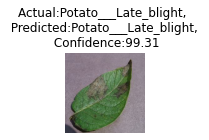

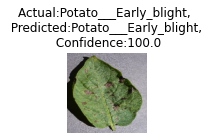

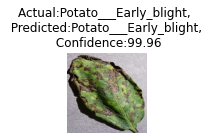

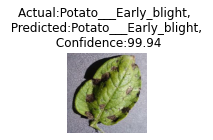

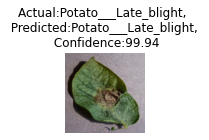

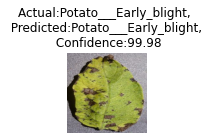

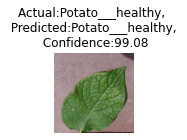

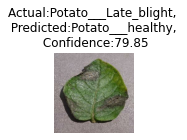

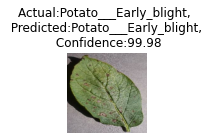

In [ ]:
for images, labels in X_test.take(1):
  for i in range(9):
    plt.figure(figsize= (5,5))
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict_disease(clf, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class}, \n Predicted:{predicted_class}, \n Confidence:{confidence}")
    plt.axis('off')

